# NowSecure Dataset Analysis and Modeling of Risky Apps

## Data Wrangling

### Approach

Our strategy is to determine the apps that are risky to have on the app store given their security posture. In this notebook we explore building machine learning models to determine how risky a given app might be from the data we have available to us about a given app.

Given the 7 groups of JSON data files, we must first wrangle the data into a single file

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
# Base directory containing group folders
base_directory = '.'  # Adjust path as needed, if the script isn't in the same location

# Create an empty dataframe to store the stacked data
final_df = pd.DataFrame()

# Loop through each directory named 'Group X'
for i in range(1, 8):  # Since there are 7 groups
    directory_path = os.path.join(base_directory, f'Group {i}')
    
    # Loop through each JSON file in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            with open(os.path.join(directory_path, filename), 'r') as f:
                data = json.load(f)
                
                # Convert JSON to dataframe and flatten the hierarchical structure
                temp_df = pd.json_normalize(data, max_level=2)  # Adjust max_level based on the depth of the JSON
                
                # Append the temp_df to final_df
                final_df = final_df.append(temp_df, ignore_index=True)

In [ ]:
final_df.shape

In [2]:
final_df.to_csv('combined_data.csv', index=False)

NameError: name 'final_df' is not defined

## Exploratory Data Analysis

After wrangling the data into a single CSV file we import the data into a dataframe and explore the dataset for interesting factors that might contribute to riskiness

In [2]:
df = pd.read_csv('combined_data.csv')

In [3]:
df.head(10)

,title,latestAnalysisRecorded,assessment.analysis.task,assessment.ref,assessment.publisherName,assessment.buildVersion,assessment.platformType,assessment.packageKey,assessment.appstoreApplicationKey,assessment.createdAt,assessment.report.score,assessment.report.findings,assessment
0,Speak & Translate - Translator,2021-06-27T09:06:04.786Z,{'dynamic': {'result': {'itunes': {'listing': ...,e6fd52ec-d726-11eb-9b8a-cbcada7fe97a,Apalon Apps,5.0.15-5.0.15.0,ios,com.appicfun.translatorfree,804641004,2021-06-27T09:06:04.786694Z,79.0,"[{'cvss': 5.3, 'impactType': 'medium', 'affect...",NaN
1,"theScore: Live Sports Scores, News, Stats & Vi...",2021-08-30T00:11:32.388Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",d50c2676-0926-11ec-b7f2-ab4c4b2e8411,Score Media Ventures Inc.,21110,android,com.fivemobile.thescore,com.fivemobile.thescore,2021-08-30T00:11:32.388267Z,81.2,"[{'cvss': 5.9, 'impactType': 'medium', 'affect...",NaN
2,FreeCell,2021-04-27T21:38:09.681Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,dc7ee16a-a7a0-11eb-b680-c3c81dfda4be,Queens Solitaire Games,111,android,com.hapogames.FreeCell,com.hapogames.FreeCell,2021-04-27T21:38:09.681925Z,48.4,"[{'cvss': 7, 'impactType': 'high', 'affected':...",NaN
3,Police Car Driving Simulator 3D: Car Games 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hearthstone,2021-09-03T05:33:56.421Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",88918dae-0c78-11ec-93df-d71260f3fb6a,"Blizzard Entertainment, Inc.",9145600,android,com.blizzard.wtcg.hearthstone,com.blizzard.wtcg.hearthstone,2021-09-03T05:33:56.421539Z,78.3,"[{'cvss': 5.9, 'impactType': 'medium', 'affect...",NaN
5,Multi-Play Video Poker™ - Free Video Poker Games,2021-07-31T21:46:44.071Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,cc74e04c-f248-11eb-ab0f-b7744fed5e2b,Ruby Seven Studios Inc.,41,android,com.rubyseven.multistrikepoker,com.rubyseven.multistrikepoker,2021-07-31T21:46:44.071720Z,85.6,"[{'cvss': 4.6, 'impactType': 'medium', 'affect...",NaN
6,EXiTS - Room Escape Game,2021-08-31T15:40:20.646Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",bff1e19e-0a71-11ec-8110-bfe8f76e53a6,NAKAYUBI CORPORATION,118,android,com.ryohei.haruki.Exit,com.ryohei.haruki.Exit,2021-08-31T15:40:20.646097Z,85.6,"[{'cvss': 4.6, 'impactType': 'medium', 'affect...",NaN
7,Video Maker,2021-09-10T03:49:16.586Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,1285ebce-11ea-11ec-ae09-d375fa76eefd,InShot Inc.,88,android,videoeditor.videomaker.videoeditorforyoutube,videoeditor.videomaker.videoeditorforyoutube,2021-09-10T03:49:16.586153Z,78.0,"[{'cvss': 5, 'impactType': 'medium', 'affected...",NaN
8,Tracks4Africa Guide,2020-06-11T13:59:40.185Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",cb47d02a-abeb-11ea-8f3e-af5d08e96e4a,Tracks4Africa,640,android,za.co.tracks4africa.guide.hybrid,za.co.tracks4africa.guide.hybrid,2020-06-11T13:59:40.185658Z,46.3,"[{'cvss': 7.5, 'impactType': 'high', 'affected...",NaN
9,Kardia,2021-08-27T13:39:06.132Z,{'dynamic': {'result': {'itunes': {'listing': ...,263c56e8-073c-11ec-8d97-7bda0dc1e472,"AliveCor, Inc.",5.18.2-1664,ios,com.alivecor.professional.aliveecg,579769143,2021-08-27T13:39:06.132276Z,50.8,"[{'cvss': 6.5, 'impactType': 'medium', 'affect...",NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   title                              194 non-null    object 
 1   latestAnalysisRecorded             166 non-null    object 
 2   assessment.analysis.task           166 non-null    object 
 3   assessment.ref                     166 non-null    object 
 4   assessment.publisherName           166 non-null    object 
 5   assessment.buildVersion            166 non-null    object 
 6   assessment.platformType            166 non-null    object 
 7   assessment.packageKey              166 non-null    object 
 8   assessment.appstoreApplicationKey  166 non-null    object 
 9   assessment.createdAt               166 non-null    object 
 10  assessment.report.score            150 non-null    float64
 11  assessment.report.findings         166 non-null    object 

In [5]:
df.describe()

,assessment.report.score,assessment
count,150.000000,0.0
mean,67.629333,NaN
std,20.167199,NaN
min,6.500000,NaN
25%,46.300000,NaN
50%,77.800000,NaN
75%,83.675000,NaN
max,100.000000,NaN


In [6]:
df.isnull().sum()

title                                  0
latestAnalysisRecorded                28
assessment.analysis.task              28
assessment.ref                        28
assessment.publisherName              28
assessment.buildVersion               28
assessment.platformType               28
assessment.packageKey                 28
assessment.appstoreApplicationKey     28
assessment.createdAt                  28
assessment.report.score               44
assessment.report.findings            28
assessment                           194
dtype: int64

We see that the data has some missing values for 28 apps, missing report score for 44 apps, and that the 'assessment' column is empty

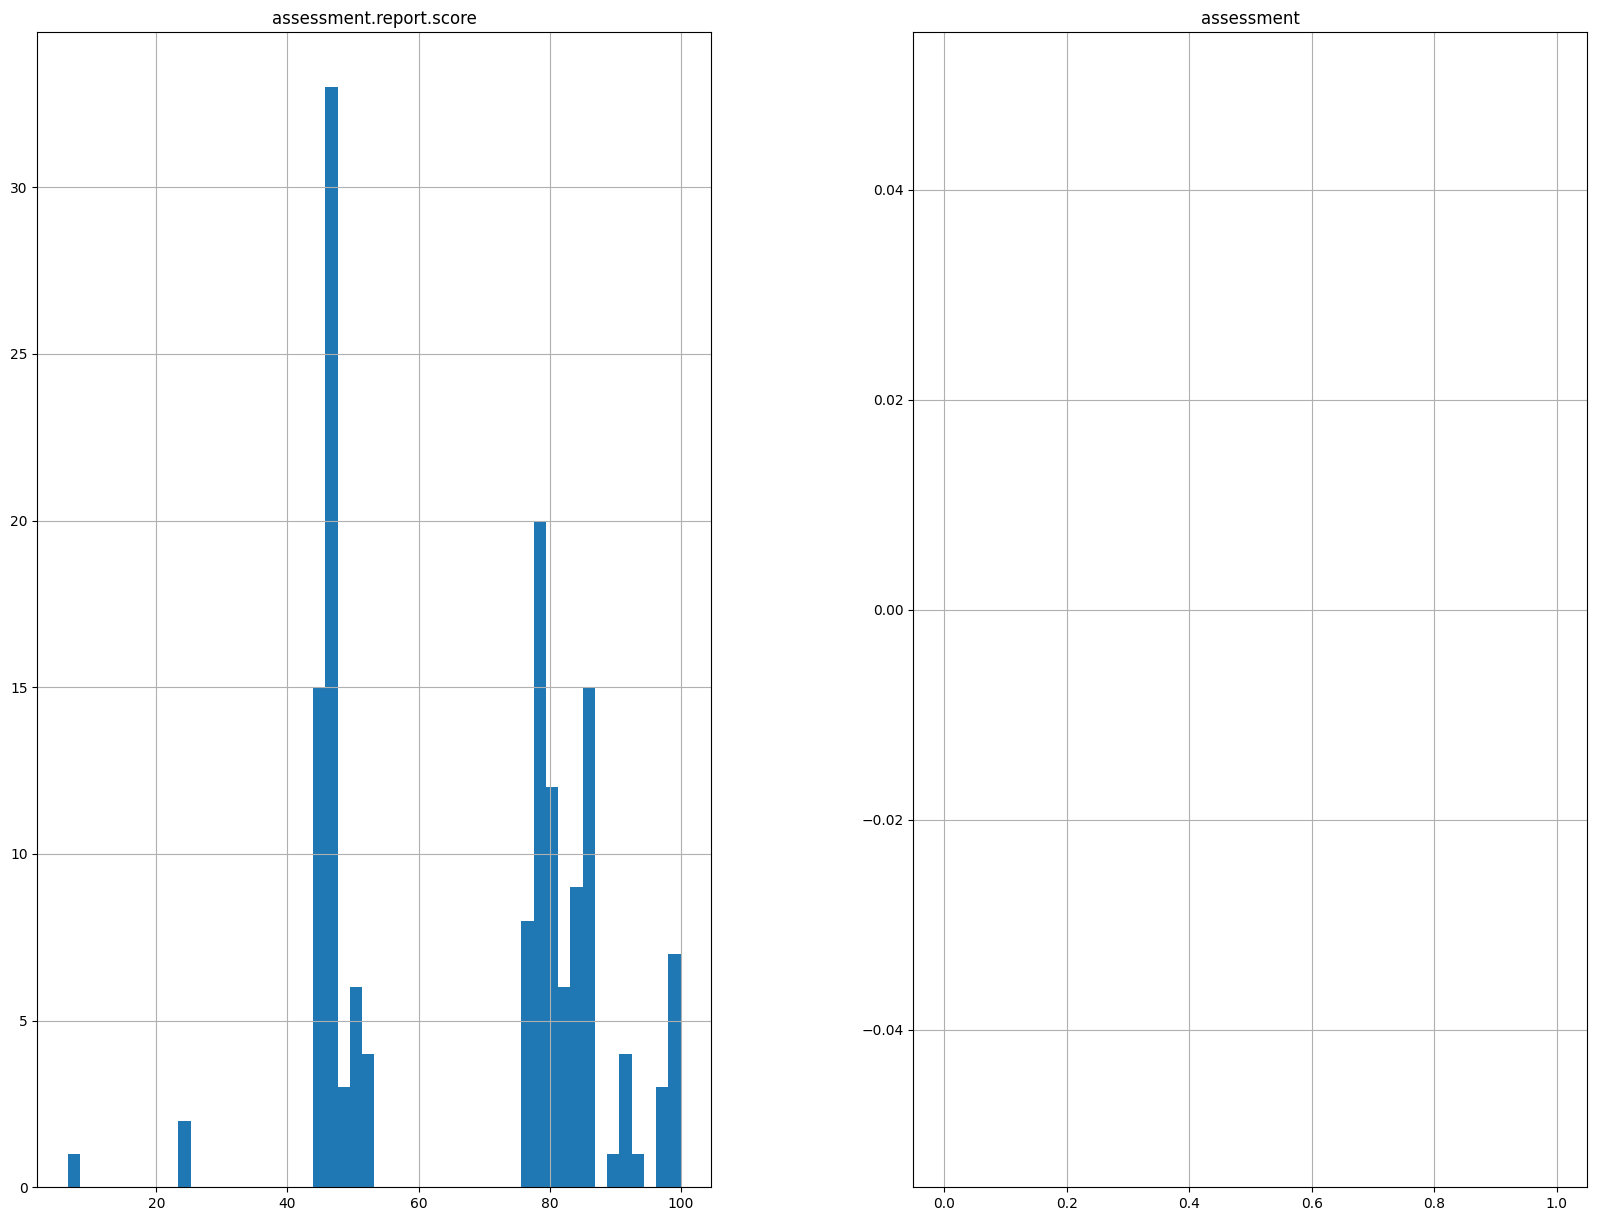

In [7]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

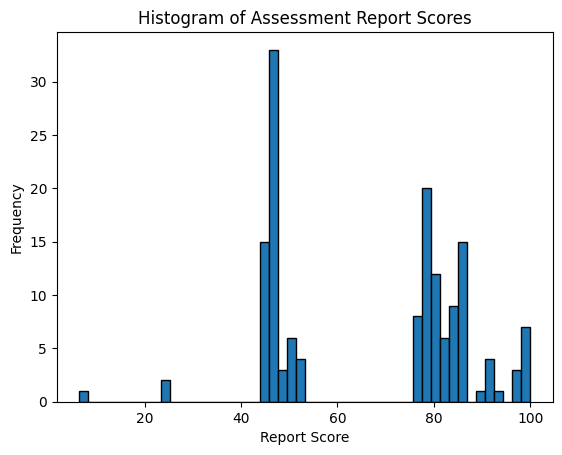

In [8]:
plt.hist(df['assessment.report.score'], bins=50, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Report Score')
plt.ylabel('Frequency')
plt.title('Histogram of Assessment Report Scores')
plt.grid(False)

# Show the histogram
plt.show()

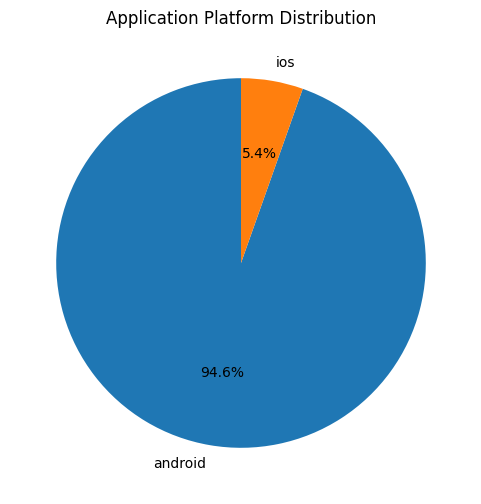

In [9]:
# Group by 'assessment.platformType' and count the number of apps
platform_counts = df['assessment.platformType'].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 6))
platform_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Application Platform Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()

In [10]:
publisher_counts = df.groupby('assessment.publisherName').size()

publisher_counts_sorted = publisher_counts.sort_values(ascending=False)

# Display the sorted counts
print(publisher_counts_sorted)

assessment.publisherName
AXS, LLC          2
Aceable, Inc.     2
YovoGames         2
10% Happier       1
RUBICON d.o.o.    1
                 ..
Gabo Apps         1
Game Pickle       1
GameSpire Ltd.    1
Gamerdev19        1
海峰 苏              1
Length: 163, dtype: int64


## Data Preprocessing

To clean up the dataset we will drop empty columns, drop rows with NaN values from any machine learning models we build, but retain the 16 rows that are just missing a single report score value

In [11]:
df_cleaned = df.drop(columns=['assessment'])

row_with_missing_values = df_cleaned[df_cleaned.isnull().any(axis=1)]

row_with_missing_values

,title,latestAnalysisRecorded,assessment.analysis.task,assessment.ref,assessment.publisherName,assessment.buildVersion,assessment.platformType,assessment.packageKey,assessment.appstoreApplicationKey,assessment.createdAt,assessment.report.score,assessment.report.findings
3,Police Car Driving Simulator 3D: Car Games 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Gospel Living,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Cell Tracker Kids,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Spectator Judging,2020-12-21T09:58:30.110Z,"{'dynamic': None, 'static': {'result': {'yaap_...",14192c76-4373-11eb-ad9a-239002ba014c,Black Horse One GmbH,547,android,com.blackhorse88.livejudging,com.blackhorse88.livejudging,2020-12-21T09:58:30.110245Z,NaN,"[{'cvss': 4.6, 'impactType': 'medium', 'affect..."
27,Find It Differences - 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,亂鬥英雄志-名將風雲錄,2020-09-29T13:09:08.633Z,"{'dynamic': None, 'static': {'result': {'yaap_...",f6113b38-0254-11eb-b17c-ef03d52f79ab,Morefun Technology Limited,1000023,android,com.gamemorefun.lstd,com.gamemorefun.lstd,2020-09-29T13:09:08.633827Z,NaN,"[{'cvss': 4.6, 'impactType': 'medium', 'affect..."
31,"InSquare Pic - Photo Editor, No Crop, Collage",2021-09-03T07:40:00.777Z,"{'dynamic': None, 'static': {'result': {'yaap_...",25463fa8-0c8a-11ec-8bd1-176f37060474,Square Quick & Pic Collage Maker,81,android,mobi.charmer.quicksquarenew,mobi.charmer.quicksquarenew,2021-09-03T07:40:00.777259Z,NaN,"[{'cvss': 5.9, 'impactType': 'medium', 'affect..."
33,Magic Piano Tiles 4：Pop Songs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,Instaqart PH: Grocery Delivery,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,Uyanık TV Box for Android TV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_cleaned = df_cleaned.dropna(subset=['latestAnalysisRecorded'])
df_cleaned

,title,latestAnalysisRecorded,assessment.analysis.task,assessment.ref,assessment.publisherName,assessment.buildVersion,assessment.platformType,assessment.packageKey,assessment.appstoreApplicationKey,assessment.createdAt,assessment.report.score,assessment.report.findings
0,Speak & Translate - Translator,2021-06-27T09:06:04.786Z,{'dynamic': {'result': {'itunes': {'listing': ...,e6fd52ec-d726-11eb-9b8a-cbcada7fe97a,Apalon Apps,5.0.15-5.0.15.0,ios,com.appicfun.translatorfree,804641004,2021-06-27T09:06:04.786694Z,79.0,"[{'cvss': 5.3, 'impactType': 'medium', 'affect..."
1,"theScore: Live Sports Scores, News, Stats & Vi...",2021-08-30T00:11:32.388Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",d50c2676-0926-11ec-b7f2-ab4c4b2e8411,Score Media Ventures Inc.,21110,android,com.fivemobile.thescore,com.fivemobile.thescore,2021-08-30T00:11:32.388267Z,81.2,"[{'cvss': 5.9, 'impactType': 'medium', 'affect..."
2,FreeCell,2021-04-27T21:38:09.681Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,dc7ee16a-a7a0-11eb-b680-c3c81dfda4be,Queens Solitaire Games,111,android,com.hapogames.FreeCell,com.hapogames.FreeCell,2021-04-27T21:38:09.681925Z,48.4,"[{'cvss': 7, 'impactType': 'high', 'affected':..."
4,Hearthstone,2021-09-03T05:33:56.421Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",88918dae-0c78-11ec-93df-d71260f3fb6a,"Blizzard Entertainment, Inc.",9145600,android,com.blizzard.wtcg.hearthstone,com.blizzard.wtcg.hearthstone,2021-09-03T05:33:56.421539Z,78.3,"[{'cvss': 5.9, 'impactType': 'medium', 'affect..."
5,Multi-Play Video Poker™ - Free Video Poker Games,2021-07-31T21:46:44.071Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,cc74e04c-f248-11eb-ab0f-b7744fed5e2b,Ruby Seven Studios Inc.,41,android,com.rubyseven.multistrikepoker,com.rubyseven.multistrikepoker,2021-07-31T21:46:44.071720Z,85.6,"[{'cvss': 4.6, 'impactType': 'medium', 'affect..."
...,...,...,...,...,...,...,...,...,...,...,...,...
186,VPN by CyberGhost - WiFi Proxy,2021-09-06T07:27:00.044Z,{'dynamic': {'result': {'itunes': {'listing': ...,d2f83696-0ee3-11ec-88ca-33dbff41a4c0,CyberGhost SRL,8.3.2-252,ios,com.cyberghostsrl.cyberghostvpn,583009522,2021-09-06T07:27:00.044174Z,82.7,"[{'cvss': 4.8, 'impactType': 'medium', 'affect..."
190,free monthly calendar app,2020-11-06T21:22:25.087Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,2a3c8e28-2076-11eb-ba0e-0392d0a5d1e7,Adcoms,10,android,com.CalendarMonthlyStyle,com.CalendarMonthlyStyle,2020-11-06T21:22:25.087856Z,46.3,"[{'cvss': 7.5, 'impactType': 'high', 'affected..."
191,Mighty Networks,2021-08-29T23:28:17.213Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",ca90818e-0920-11ec-901c-47edd37979c6,Mighty Networks,500985,android,com.mightybell.mb,com.mightybell.mb,2021-08-29T23:28:17.213337Z,85.6,"[{'cvss': 4.6, 'impactType': 'medium', 'affect..."
192,Trip Agent,2021-06-08T14:48:49.924Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,a36321be-c868-11eb-a83b-8b9fb43ce064,mTrip apps,141,android,com.mtrip.tripagent,com.mtrip.tripagent,2021-06-08T14:48:49.924905Z,79.2,"[{'cvss': 5, 'impactType': 'medium', 'affected..."


## Feature Engineering

The lower the report score for a given app, the less secure the app is considered according to NowSecure. As such, the approach taken to determine the riskiness of an app will be by building a regression model to determine the Assessment Report Score.

As part of the regression model that we will build, we will use various other columns in the dataset as features (X) and to predict the target variable (Y) of report score. Some of these other features will be the count of the number of findings that we will extract from the 'assessment.report.findings' column to get a count of the number of different types of findings by severity for each app on the app store.

In [13]:
import re
from collections import Counter

def count_severities(findings_str):
    # Regular expression to match the 'impactType' and its value
    regex = r"'impactType': '([^']*)'"

    # Find all matches in the string
    matches = re.findall(regex, findings_str)

    # Count occurrences of each severity
    severity_count = Counter(matches)

    return dict(severity_count)

In [14]:
df_cleaned['severity_counts'] = df_cleaned['assessment.report.findings'].apply(count_severities)
df_cleaned['severity_counts'][0]

{'medium': 3, 'low': 2, 'warn': 4, 'info': 18, 'artifact': 2, 'pass': 89}

In [15]:
# Step 1: Get all unique severity types from all rows
all_severities = set()
df_cleaned['severity_counts'].apply(lambda x: all_severities.update(x.keys()))

# Step 2: Iterate through each row and update new columns
for severity in all_severities:
    column_name = f'count_{severity}_findings'
    df_cleaned[column_name] = df_cleaned['severity_counts'].apply(lambda x: x.get(severity, 0))

# Now df_cleaned contains new columns for each severity type
df_cleaned

,title,latestAnalysisRecorded,assessment.analysis.task,assessment.ref,assessment.publisherName,assessment.buildVersion,assessment.platformType,assessment.packageKey,assessment.appstoreApplicationKey,assessment.createdAt,...,assessment.report.findings,severity_counts,count_low_findings,count_info_findings,count_critical_findings,count_medium_findings,count_warn_findings,count_high_findings,count_pass_findings,count_artifact_findings
0,Speak & Translate - Translator,2021-06-27T09:06:04.786Z,{'dynamic': {'result': {'itunes': {'listing': ...,e6fd52ec-d726-11eb-9b8a-cbcada7fe97a,Apalon Apps,5.0.15-5.0.15.0,ios,com.appicfun.translatorfree,804641004,2021-06-27T09:06:04.786694Z,...,"[{'cvss': 5.3, 'impactType': 'medium', 'affect...","{'medium': 3, 'low': 2, 'warn': 4, 'info': 18,...",2,18,0,3,4,0,89,2
1,"theScore: Live Sports Scores, News, Stats & Vi...",2021-08-30T00:11:32.388Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",d50c2676-0926-11ec-b7f2-ab4c4b2e8411,Score Media Ventures Inc.,21110,android,com.fivemobile.thescore,com.fivemobile.thescore,2021-08-30T00:11:32.388267Z,...,"[{'cvss': 5.9, 'impactType': 'medium', 'affect...","{'medium': 1, 'low': 1, 'warn': 1, 'info': 14,...",1,14,0,1,1,0,111,2
2,FreeCell,2021-04-27T21:38:09.681Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,dc7ee16a-a7a0-11eb-b680-c3c81dfda4be,Queens Solitaire Games,111,android,com.hapogames.FreeCell,com.hapogames.FreeCell,2021-04-27T21:38:09.681925Z,...,"[{'cvss': 7, 'impactType': 'high', 'affected':...","{'high': 1, 'low': 3, 'warn': 3, 'info': 12, '...",3,12,0,0,3,1,112,2
4,Hearthstone,2021-09-03T05:33:56.421Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",88918dae-0c78-11ec-93df-d71260f3fb6a,"Blizzard Entertainment, Inc.",9145600,android,com.blizzard.wtcg.hearthstone,com.blizzard.wtcg.hearthstone,2021-09-03T05:33:56.421539Z,...,"[{'cvss': 5.9, 'impactType': 'medium', 'affect...","{'medium': 2, 'low': 3, 'warn': 1, 'info': 10,...",3,10,0,2,1,0,113,2
5,Multi-Play Video Poker™ - Free Video Poker Games,2021-07-31T21:46:44.071Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,cc74e04c-f248-11eb-ab0f-b7744fed5e2b,Ruby Seven Studios Inc.,41,android,com.rubyseven.multistrikepoker,com.rubyseven.multistrikepoker,2021-07-31T21:46:44.071720Z,...,"[{'cvss': 4.6, 'impactType': 'medium', 'affect...","{'medium': 1, 'warn': 1, 'info': 11, 'artifact...",0,11,0,1,1,0,111,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,VPN by CyberGhost - WiFi Proxy,2021-09-06T07:27:00.044Z,{'dynamic': {'result': {'itunes': {'listing': ...,d2f83696-0ee3-11ec-88ca-33dbff41a4c0,CyberGhost SRL,8.3.2-252,ios,com.cyberghostsrl.cyberghostvpn,583009522,2021-09-06T07:27:00.044174Z,...,"[{'cvss': 4.8, 'impactType': 'medium', 'affect...","{'medium': 2, 'low': 2, 'warn': 3, 'info': 18,...",2,18,0,2,3,0,89,2
190,free monthly calendar app,2020-11-06T21:22:25.087Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,2a3c8e28-2076-11eb-ba0e-0392d0a5d1e7,Adcoms,10,android,com.CalendarMonthlyStyle,com.CalendarMonthlyStyle,2020-11-06T21:22:25.087856Z,...,"[{'cvss': 7.5, 'impactType': 'high', 'affected...","{'high': 1, 'medium': 2, 'low': 3, 'warn': 1, ...",3,10,0,2,1,1,136,2
191,Mighty Networks,2021-08-29T23:28:17.213Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",ca90818e-0920-11ec-901c-47edd37979c6,Mighty Networks,500985,android,com.mightybell.mb,com.mightybell.mb,2021-08-29T23:28:17.213337Z,...,"[{'cvss': 4.6, 'impactType': 'medium', 'affect...","{'medium': 1, 'warn': 1, 'info': 11, 'artifact...",0,11,0,1,1,0,109,2
192,Trip Agent,2021-06-08T14:48:49.924Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,a36321be-c868-11eb-a83b-8b9fb43ce064,mTrip apps,141,android,com.mtrip.tripagent,com.mtrip.tripagent,2021-06-08T14:48:49.924905Z,...,"[{'cvss': 5, 'impactType': 'medium', 'affected...","{'medium': 2, 'low': 4, 'warn': 2, 'info': 13,...",4,13,0,2,2,0,108,2


In [31]:
#'count_critical_findings', 'count_high_findings', 'count_medium_findings', 'count_warn_findings','count_pass_findings', 'count_info_findings', 'count_artifact_findings', 'assessment.report.score'] 

# Select the last 8 columns
last_eight_columns = df_cleaned.iloc[:, -8:]

# Select the additional named columns
additional_columns = df_cleaned[['assessment.platformType', 'assessment.report.score']]

# Concatenate the columns to create a new DataFrame
new_df = pd.concat([additional_columns, last_eight_columns], axis=1)
new_df

,assessment.platformType,assessment.report.score,count_low_findings,count_info_findings,count_critical_findings,count_medium_findings,count_warn_findings,count_high_findings,count_pass_findings,count_artifact_findings
0,ios,79.0,2,18,0,3,4,0,89,2
1,android,81.2,1,14,0,1,1,0,111,2
2,android,48.4,3,12,0,0,3,1,112,2
4,android,78.3,3,10,0,2,1,0,113,2
5,android,85.6,0,11,0,1,1,0,111,2
...,...,...,...,...,...,...,...,...,...,...
186,ios,82.7,2,18,0,2,3,0,89,2
190,android,46.3,3,10,0,2,1,1,136,2
191,android,85.6,0,11,0,1,1,0,109,2
192,android,79.2,4,13,0,2,2,0,108,2


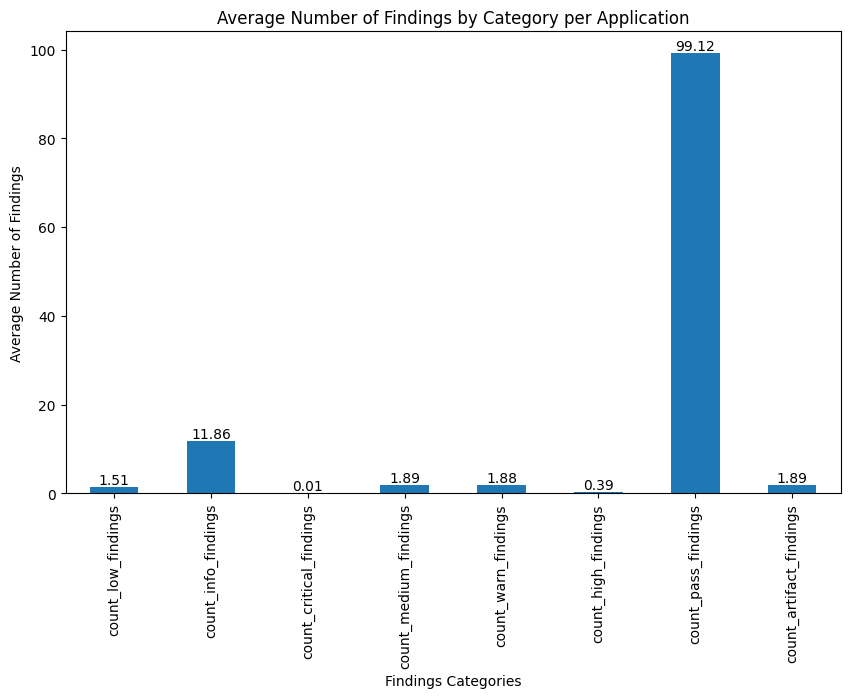

In [17]:
# Sample data (assuming 'findings_averages' is a pandas Series)
findings_averages = new_df.filter(like='count_').mean()

# Create a bar graph using these averages.
ax = findings_averages.plot(kind='bar', figsize=(10, 6))

# Set the title and labels for the plot.
plt.title('Average Number of Findings by Category per Application')
plt.xlabel('Findings Categories')
plt.ylabel('Average Number of Findings')

# Add labels to the bars
for i, v in enumerate(findings_averages):
    ax.text(i, v, str(round(v, 2)), ha='center', va='bottom')

# Show the plot.
plt.show()

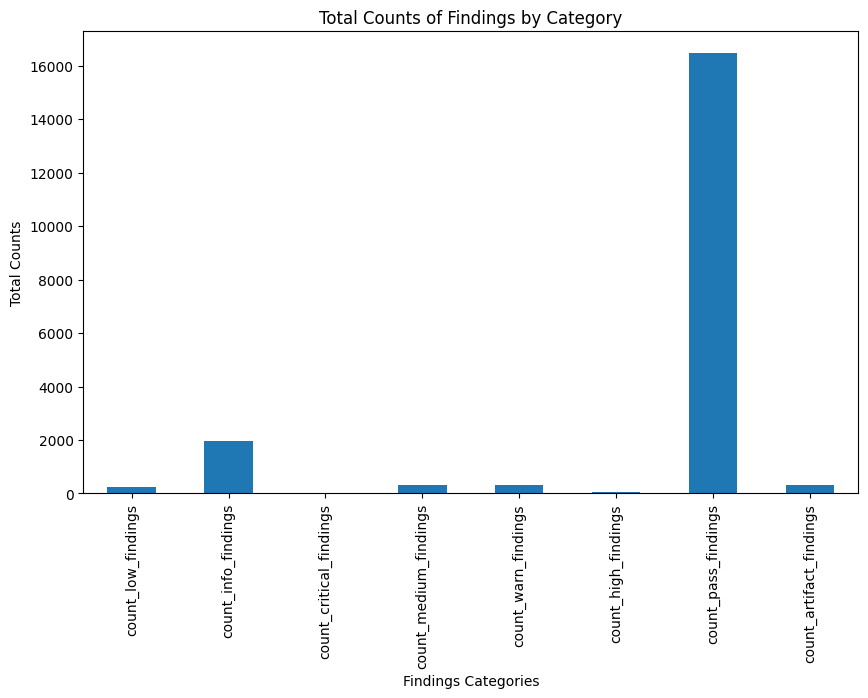

In [18]:
# This assumes 'new_df' is your DataFrame with the findings data.
findings_totals = new_df.filter(like='count_').sum()

# Create a bar graph using these totals.
findings_totals.plot(kind='bar', figsize=(10, 6))

# Set the title and labels for the plot.
plt.title('Total Counts of Findings by Category')
plt.xlabel('Findings Categories')
plt.ylabel('Total Counts')

# Show the plot.
plt.show()

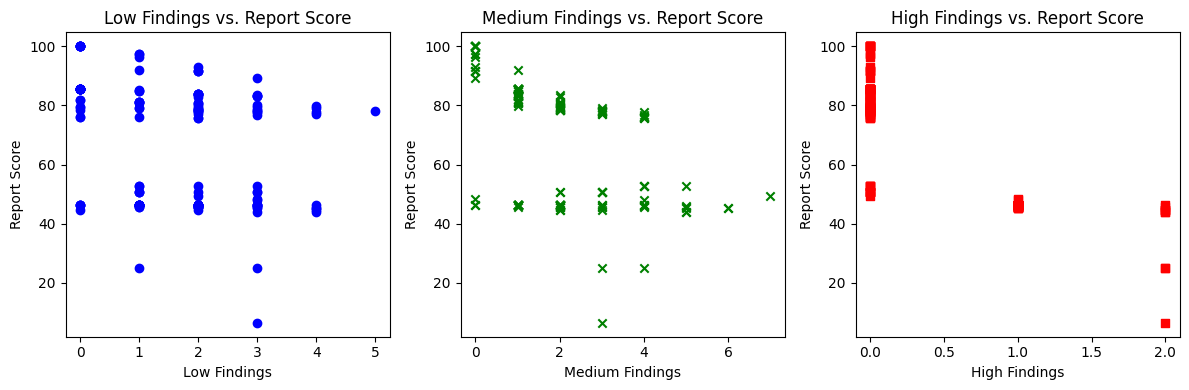

In [19]:
plt.figure(figsize=(12, 4))

# Low Findings vs. Report Score
plt.subplot(131)
plt.scatter(new_df['count_low_findings'], new_df['assessment.report.score'], color='blue', marker='o')
plt.xlabel('Low Findings')
plt.ylabel('Report Score')
plt.title('Low Findings vs. Report Score')

# Medium Findings vs. Report Score
plt.subplot(132)
plt.scatter(new_df['count_medium_findings'], new_df['assessment.report.score'], color='green', marker='x')
plt.xlabel('Medium Findings')
plt.ylabel('Report Score')
plt.title('Medium Findings vs. Report Score')

# High Findings vs. Report Score
plt.subplot(133)
plt.scatter(new_df['count_high_findings'], new_df['assessment.report.score'], color='red', marker='s')
plt.xlabel('High Findings')
plt.ylabel('Report Score')
plt.title('High Findings vs. Report Score')

plt.tight_layout()
plt.show()

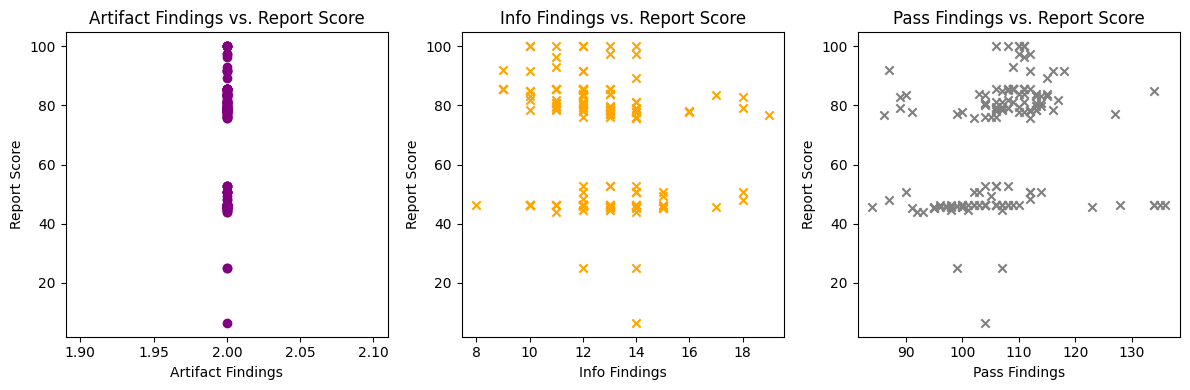

In [20]:
plt.figure(figsize=(12, 4))

# Artifact Findings vs. Report Score
plt.subplot(131)
plt.scatter(new_df['count_artifact_findings'], new_df['assessment.report.score'], color='purple', marker='o')
plt.xlabel('Artifact Findings')
plt.ylabel('Report Score')
plt.title('Artifact Findings vs. Report Score')

# Artifact Findings vs. Report Score
plt.subplot(132)
plt.scatter(new_df['count_info_findings'], new_df['assessment.report.score'], color='orange', marker='x')
plt.xlabel('Info Findings')
plt.ylabel('Report Score')
plt.title('Info Findings vs. Report Score')

# Artifact Findings vs. Report Score
plt.subplot(133)
plt.scatter(new_df['count_pass_findings'], new_df['assessment.report.score'], color='gray', marker='x')
plt.xlabel('Pass Findings')
plt.ylabel('Report Score')
plt.title('Pass Findings vs. Report Score')

plt.tight_layout()
plt.show()

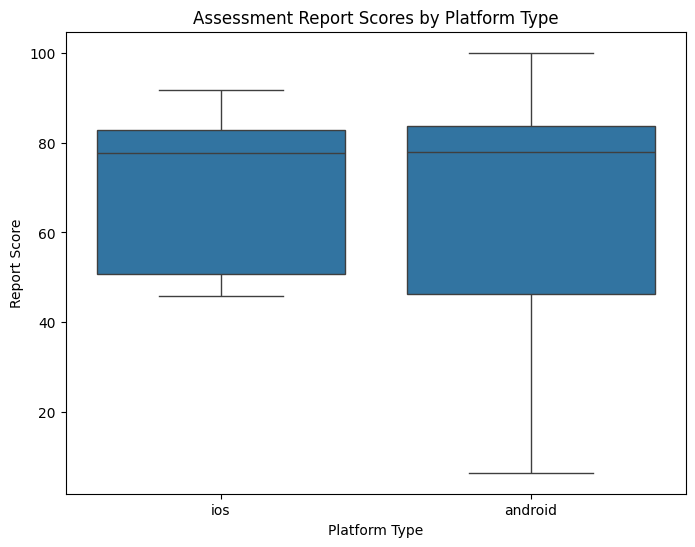

In [21]:
# Create a box plot of report scores for each platform category
plt.figure(figsize=(8, 6))
sns.boxplot(x='assessment.platformType', y='assessment.report.score', data=new_df)
plt.xlabel('Platform Type')
plt.ylabel('Report Score')
plt.title('Assessment Report Scores by Platform Type')
plt.show()

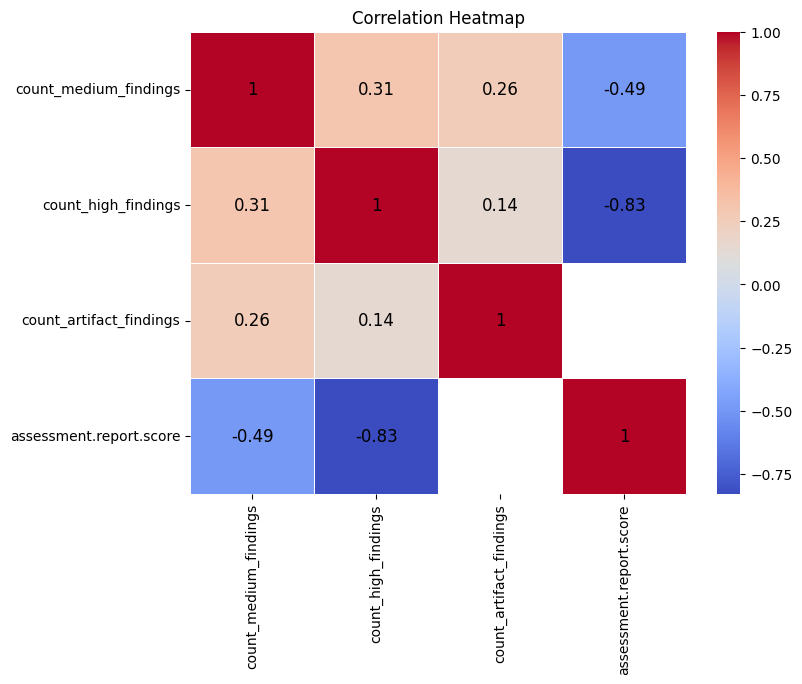

In [22]:
# Select the columns of interest
columns_of_interest = ['count_medium_findings', 'count_high_findings', 'count_artifact_findings', 'assessment.report.score']

# Create a correlation matrix
correlation_matrix = new_df[columns_of_interest].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"color": 'black', "fontsize": 12})
plt.title('Correlation Heatmap')
plt.show()

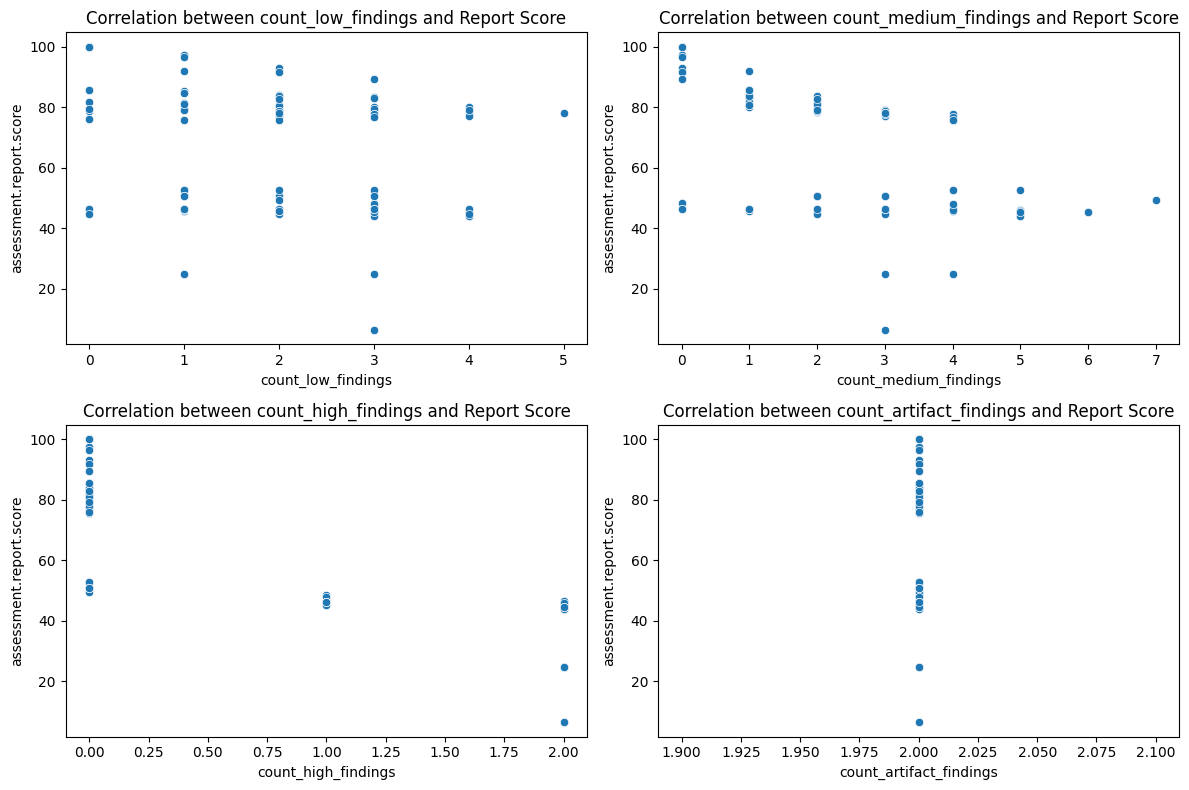

In [29]:
# List of columns to calculate correlations with 'assessment.report.score'
columns_to_correlate = ['count_low_findings', 'count_medium_findings', 'count_high_findings', 'count_artifact_findings']

# Create subplots for correlation scatter plots
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns_to_correlate, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=new_df[column], y=new_df['assessment.report.score'])
    plt.title(f'Correlation between {column} and Report Score')

plt.tight_layout()
plt.show()

In [32]:
one_hot = pd.get_dummies(new_df['assessment.platformType'], prefix='platformType')
new_df = new_df.join(one_hot)
new_df

,assessment.platformType,assessment.report.score,count_low_findings,count_info_findings,count_critical_findings,count_medium_findings,count_warn_findings,count_high_findings,count_pass_findings,count_artifact_findings,platformType_android,platformType_ios
0,ios,79.0,2,18,0,3,4,0,89,2,False,True
1,android,81.2,1,14,0,1,1,0,111,2,True,False
2,android,48.4,3,12,0,0,3,1,112,2,True,False
4,android,78.3,3,10,0,2,1,0,113,2,True,False
5,android,85.6,0,11,0,1,1,0,111,2,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
186,ios,82.7,2,18,0,2,3,0,89,2,False,True
190,android,46.3,3,10,0,2,1,1,136,2,True,False
191,android,85.6,0,11,0,1,1,0,109,2,True,False
192,android,79.2,4,13,0,2,2,0,108,2,True,False


In [36]:
X = new_df.iloc[:,2:]
Y = new_df['assessment.report.score']

In [37]:
X

,count_low_findings,count_info_findings,count_critical_findings,count_medium_findings,count_warn_findings,count_high_findings,count_pass_findings,count_artifact_findings,platformType_android,platformType_ios
0,2,18,0,3,4,0,89,2,False,True
1,1,14,0,1,1,0,111,2,True,False
2,3,12,0,0,3,1,112,2,True,False
4,3,10,0,2,1,0,113,2,True,False
5,0,11,0,1,1,0,111,2,True,False
...,...,...,...,...,...,...,...,...,...,...
186,2,18,0,2,3,0,89,2,False,True
190,3,10,0,2,1,1,136,2,True,False
191,0,11,0,1,1,0,109,2,True,False
192,4,13,0,2,2,0,108,2,True,False


In [38]:
Y

0      79.0
1      81.2
2      48.4
4      78.3
5      85.6
       ... 
186    82.7
190    46.3
191    85.6
192    79.2
193    75.9
Name: assessment.report.score, Length: 166, dtype: float64

In [39]:
# Assuming df is your original DataFrame and Y is the target column
X = new_df.drop(columns=['assessment.report.score'])  # Replace 'Y' with the actual name of your target column
X = new_df.iloc[:,2:]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to your data and transform it
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame with original indices
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df

,count_low_findings,count_info_findings,count_critical_findings,count_medium_findings,count_warn_findings,count_high_findings,count_pass_findings,count_artifact_findings,platformType_android,platformType_ios
0,0.399739,2.146308,-0.07785,0.762273,1.333754,-0.644920,-0.372809,0.312019,-4.176655,4.176655
1,-0.409488,0.749104,-0.07785,-0.605698,-0.553205,-0.644920,0.437606,0.312019,0.239426,-0.239426
2,1.208965,0.050501,-0.07785,-1.289683,0.704768,1.027842,0.474443,0.312019,0.239426,-0.239426
4,1.208965,-0.648101,-0.07785,0.078287,-0.553205,-0.644920,0.511280,0.312019,0.239426,-0.239426
5,-1.218715,-0.298800,-0.07785,-0.605698,-0.553205,-0.644920,0.437606,0.312019,0.239426,-0.239426
...,...,...,...,...,...,...,...,...,...,...
186,0.399739,2.146308,-0.07785,0.078287,0.704768,-0.644920,-0.372809,0.312019,-4.176655,4.176655
190,1.208965,-0.648101,-0.07785,0.078287,-0.553205,1.027842,1.358532,0.312019,0.239426,-0.239426
191,-1.218715,-0.298800,-0.07785,-0.605698,-0.553205,-0.644920,0.363932,0.312019,0.239426,-0.239426
192,2.018192,0.399802,-0.07785,0.078287,0.075782,-0.644920,0.327095,0.312019,0.239426,-0.239426


In [40]:
# Convert Y to a DataFrame with the same index as X_scaled_df
Y_df = Y.reindex(X_scaled_df.index).to_frame(name='target')

# Split the data into train and test based on missing values in Y
train_data = X_scaled_df[~Y_df['target'].isna()]
test_data = X_scaled_df[Y_df['target'].isna()]

train_target = Y_df[~Y_df['target'].isna()]
test_target = Y_df[Y_df['target'].isna()]


In [41]:
train_data

,count_low_findings,count_info_findings,count_critical_findings,count_medium_findings,count_warn_findings,count_high_findings,count_pass_findings,count_artifact_findings,platformType_android,platformType_ios
0,0.399739,2.146308,-0.07785,0.762273,1.333754,-0.644920,-0.372809,0.312019,-4.176655,4.176655
1,-0.409488,0.749104,-0.07785,-0.605698,-0.553205,-0.644920,0.437606,0.312019,0.239426,-0.239426
2,1.208965,0.050501,-0.07785,-1.289683,0.704768,1.027842,0.474443,0.312019,0.239426,-0.239426
4,1.208965,-0.648101,-0.07785,0.078287,-0.553205,-0.644920,0.511280,0.312019,0.239426,-0.239426
5,-1.218715,-0.298800,-0.07785,-0.605698,-0.553205,-0.644920,0.437606,0.312019,0.239426,-0.239426
...,...,...,...,...,...,...,...,...,...,...
186,0.399739,2.146308,-0.07785,0.078287,0.704768,-0.644920,-0.372809,0.312019,-4.176655,4.176655
190,1.208965,-0.648101,-0.07785,0.078287,-0.553205,1.027842,1.358532,0.312019,0.239426,-0.239426
191,-1.218715,-0.298800,-0.07785,-0.605698,-0.553205,-0.644920,0.363932,0.312019,0.239426,-0.239426
192,2.018192,0.399802,-0.07785,0.078287,0.075782,-0.644920,0.327095,0.312019,0.239426,-0.239426


In [42]:
test_data

,count_low_findings,count_info_findings,count_critical_findings,count_medium_findings,count_warn_findings,count_high_findings,count_pass_findings,count_artifact_findings,platformType_android,platformType_ios
20,-0.409488,-2.743908,-0.07785,-0.605698,-0.553205,-0.644920,-3.282935,-2.565488,0.239426,-0.239426
28,-0.409488,-2.743908,-0.07785,-0.605698,-0.553205,-0.644920,-3.282935,-2.565488,0.239426,-0.239426
31,-1.218715,-2.394606,-0.07785,0.078287,-0.553205,-0.644920,-3.319772,-2.565488,0.239426,-0.239426
41,-1.218715,-2.045305,-0.07785,-1.289683,-1.182191,1.027842,-2.030475,-5.442996,0.239426,-0.239426
44,-1.218715,-2.394606,-0.07785,-0.605698,-1.182191,-0.644920,-3.246098,-2.565488,0.239426,-0.239426
61,-1.218715,-2.394606,-0.07785,-1.289683,-1.182191,-0.644920,-1.993638,-5.442996,0.239426,-0.239426
63,-1.218715,-2.394606,-0.07785,-1.289683,-1.182191,-0.644920,-3.209261,-2.565488,0.239426,-0.239426
69,-1.218715,-1.346703,-0.07785,-1.289683,0.075782,-0.644920,0.805977,-2.565488,0.239426,-0.239426
98,-1.218715,-2.394606,-0.07785,-0.605698,-1.182191,-0.644920,-3.246098,-2.565488,0.239426,-0.239426
102,-0.409488,-2.394606,-0.07785,0.078287,-1.182191,-0.644920,-3.393446,-2.565488,0.239426,-0.239426


In [43]:
train_target

,target
0,79.0
1,81.2
2,48.4
4,78.3
5,85.6
...,...
186,82.7
190,46.3
191,85.6
192,79.2


In [44]:
test_target

,target
20,NaN
28,NaN
31,NaN
41,NaN
44,NaN
61,NaN
63,NaN
69,NaN
98,NaN
102,NaN


In [45]:
np.random.seed(42)

# Function to perform stepwise regression
def stepwise_regression(train_data, train_target):
    included = []
    while True:
        changed = False
        # Loop over all features not yet included
        for new_column in train_data.columns.difference(included):
            model = sm.OLS(train_target, sm.add_constant(train_data[included + [new_column]])).fit()
            p_values = model.pvalues.iloc[1:]  # exclude intercept
            worst_pval = p_values.max()  # highest p-value
            if worst_pval < 0.05:  # significance level
                included.append(new_column)
                changed = True
        if not changed:
            break

    final_model = sm.OLS(train_target, sm.add_constant(train_data[included])).fit()
    return final_model

# Run the stepwise regression
model = stepwise_regression(train_data, train_target['target'])

# Print summary of final model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     8.909
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           2.16e-07
Time:                        11:27:46   Log-Likelihood:                -642.73
No. Observations:                 150   AIC:                             1297.
Df Residuals:                     144   BIC:                             1316.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
count_low_findings        

Given the selected p value of 0.05, we expect the features of the dataset that had a p value less than 0.05 to be statistically significant in predicting report score. From the results above we see that we should extract the following features selected by the stepwise regression model - Count Medium, Count High, Count Critical Findings, and Count Artifact Findings

However, from our exploratory data analysis we know that the Count of Critical Findings is only applicable to a single app that had a finding of that severity. As such, we will not use this as a feature for the final linear regression model

In [46]:
# Data Preprocessing
# Select relevant columns for prediction

features =['count_artifact_findings', 'count_medium_findings', 'count_high_findings']
train_data = train_data[features]
test_data = test_data[features]

In [47]:
# Split train_data further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size=0.7, random_state=42)

# Building the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the training data
y_train_pred = model.predict(X_train)

# Calculating the RMSE for the training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE: {train_rmse}")

# Evaluating the Model
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE: {val_rmse}")

# Predicting Scores for test_data
test_predictions = model.predict(test_data).ravel()

# Assuming test_target is a DataFrame with the same index as test_data
test_target['predicted_target'] = pd.Series(test_predictions, index=test_data.index)

Training RMSE: 11.292455462344194
Validation RMSE: 10.00208535523441


/var/folders/xq/82lk4pls34q1p015xptftv9h0000gn/T/ipykernel_12773/2247473183.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_target['predicted_target'] = pd.Series(test_predictions, index=test_data.index)


In [48]:
test_target

,target,predicted_target
20,NaN,77.757586
28,NaN,77.757586
31,NaN,75.219515
41,NaN,57.423747
44,NaN,77.757586
61,NaN,80.295658
63,NaN,80.295658
69,NaN,80.295658
98,NaN,77.757586
102,NaN,75.219515


Based on our machine learning model we see that for the 16 apps for which we had no report scores, our model predicts that most of the apps had a report score in the range of 75-80, with the exception of 1 app - row 41 which had a predicted report score of 57. We can go back to the original data to see what attributes this application to see why it is predicted to have higher risk

In [49]:
new_df.loc[41]

assessment.platformType    android
assessment.report.score        NaN
count_low_findings               0
count_info_findings              6
count_critical_findings          0
count_medium_findings            0
count_warn_findings              0
count_high_findings              1
count_pass_findings             44
count_artifact_findings          0
platformType_android          True
platformType_ios             False
Name: 41, dtype: object

In [50]:
new_df.count_high_findings.value_counts()

count_high_findings
0    112
1     44
2     10
Name: count, dtype: int64

After taking a closer look at the data values for this particular app from row 41 of the data, we see that the app had 1 high finding, which is most likely why our model has predicted it to have a lower report score and is thus high risk.

In conclusion, it appears that based off the data we have, that our model is performing as expected and is serving to be able to predict the riskiness of an app somewhat reliably based off the features we have provided it with. Those being, the count of medium, high, and artifact findings to predict report score.

In [52]:
live_test_data = df_cleaned[df_cleaned['assessment.report.score'].isna()]
live_test_data

,title,latestAnalysisRecorded,assessment.analysis.task,assessment.ref,assessment.publisherName,assessment.buildVersion,assessment.platformType,assessment.packageKey,assessment.appstoreApplicationKey,assessment.createdAt,...,assessment.report.findings,severity_counts,count_low_findings,count_info_findings,count_critical_findings,count_medium_findings,count_warn_findings,count_high_findings,count_pass_findings,count_artifact_findings
20,Spectator Judging,2020-12-21T09:58:30.110Z,"{'dynamic': None, 'static': {'result': {'yaap_...",14192c76-4373-11eb-ad9a-239002ba014c,Black Horse One GmbH,547,android,com.blackhorse88.livejudging,com.blackhorse88.livejudging,2020-12-21T09:58:30.110245Z,...,"[{'cvss': 4.6, 'impactType': 'medium', 'affect...","{'medium': 1, 'low': 1, 'warn': 1, 'info': 4, ...",1,4,0,1,1,0,10,1
28,亂鬥英雄志-名將風雲錄,2020-09-29T13:09:08.633Z,"{'dynamic': None, 'static': {'result': {'yaap_...",f6113b38-0254-11eb-b17c-ef03d52f79ab,Morefun Technology Limited,1000023,android,com.gamemorefun.lstd,com.gamemorefun.lstd,2020-09-29T13:09:08.633827Z,...,"[{'cvss': 4.6, 'impactType': 'medium', 'affect...","{'medium': 1, 'low': 1, 'warn': 1, 'info': 4, ...",1,4,0,1,1,0,10,1
31,"InSquare Pic - Photo Editor, No Crop, Collage",2021-09-03T07:40:00.777Z,"{'dynamic': None, 'static': {'result': {'yaap_...",25463fa8-0c8a-11ec-8bd1-176f37060474,Square Quick & Pic Collage Maker,81,android,mobi.charmer.quicksquarenew,mobi.charmer.quicksquarenew,2021-09-03T07:40:00.777259Z,...,"[{'cvss': 5.9, 'impactType': 'medium', 'affect...","{'medium': 2, 'warn': 1, 'info': 5, 'artifact'...",0,5,0,2,1,0,9,1
41,OneMain Financial - Personal Loans,2021-06-05T02:24:43.309Z,"{'dynamic': {'result': {'fs_issues': [], 'ipc_...",ebcebaba-ba59-11e7-a683-a72a79a5e6f6,OneMain Financial,20150216,android,com.springleaf.mobile,com.springleaf.mobile,2016-08-15T06:15:01.408213Z,...,"[{'cvss': 7.5, 'impactType': 'high', 'affected...","{'high': 1, 'info': 6, 'pass': 44}",0,6,0,0,0,1,44,0
44,School of Dragons,2021-08-25T07:17:17.444Z,"{'dynamic': None, 'static': {'result': {'yaap_...",7ac91f12-0574-11ec-a4ca-c31604a7cb0a,JumpStart Games,131,android,com.KnowledgeAdventure.SchoolOfDragons,com.KnowledgeAdventure.SchoolOfDragons,2021-08-25T07:17:17.444253Z,...,"[{'cvss': 4.6, 'impactType': 'medium', 'affect...","{'medium': 1, 'info': 5, 'artifact': 1, 'pass'...",0,5,0,1,0,0,11,1
61,Smart Card ATR Analyzer,2016-08-15T06:15:01.408Z,"{'dynamic': {'result': {'fs_issues': [], 'ipc_...",ebae1d28-ba59-11e7-bc5f-fb1da45f9c92,SC & Droid,3,android,com.scdroid.atranalyzer,com.scdroid.atranalyzer,2016-08-15T06:15:01.408213Z,...,"[{'cvss': 0, 'impactType': 'info', 'affected':...","{'info': 5, 'pass': 45}",0,5,0,0,0,0,45,0
63,Epson Print Enabler,2021-03-06T06:46:57.588Z,"{'dynamic': None, 'static': {'result': {'yaap_...",bef569fc-7e47-11eb-b67e-b7de92c59c1e,Seiko Epson Corporation,10101,android,com.epson.mobilephone.android.epsonprintservic...,com.epson.mobilephone.android.epsonprintservic...,2021-03-06T06:46:57.588678Z,...,"[{'cvss': 0, 'impactType': 'info', 'affected':...","{'info': 5, 'artifact': 1, 'pass': 12}",0,5,0,0,0,0,12,1
69,Your Texas Benefits,2020-12-24T14:54:15.402Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",e467ad90-45f7-11eb-a9a7-9b7b42b8da99,Texas Health & Human Services Commission,59030,android,us.tx.state.hhsc.ytbmobile,us.tx.state.hhsc.ytbmobile,2020-12-24T14:54:15.402246Z,...,"[{'cvss': 0, 'impactType': 'warn', 'affected':...","{'warn': 2, 'info': 8, 'artifact': 1, 'pass': ...",0,8,0,0,2,0,121,1
98,Shadowgun War Games - Online PvP FPS,2020-07-25T10:07:42.030Z,"{'dynamic': None, 'static': {'result': {'yaap_...",ad95bc14-ce5e-11ea-bb09-079c1b20b44e,MADFINGER Games,2500037,android,com.madfingergames.wargames.shooter,com.madfingergames.wargames.shooter,2020-07-25T10:07:42.030225Z,...,"[{'cvss': 4.6, 'impactType': 'medium', 'affect...","{'medium': 1, 'info': 5, 'artifact': 1, 'pass'...",0,5,0,1,0,0,11,1
102,Army Toy Men Survival War Shooting Counter Off...,2019-12-13T18:21:36

In [53]:
merged_test_data = live_test_data.merge(test_target, left_index=True, right_index=True)
merged_test_data

,title,latestAnalysisRecorded,assessment.analysis.task,assessment.ref,assessment.publisherName,assessment.buildVersion,assessment.platformType,assessment.packageKey,assessment.appstoreApplicationKey,assessment.createdAt,...,count_low_findings,count_info_findings,count_critical_findings,count_medium_findings,count_warn_findings,count_high_findings,count_pass_findings,count_artifact_findings,target,predicted_target
20,Spectator Judging,2020-12-21T09:58:30.110Z,"{'dynamic': None, 'static': {'result': {'yaap_...",14192c76-4373-11eb-ad9a-239002ba014c,Black Horse One GmbH,547,android,com.blackhorse88.livejudging,com.blackhorse88.livejudging,2020-12-21T09:58:30.110245Z,...,1,4,0,1,1,0,10,1,NaN,77.757586
28,亂鬥英雄志-名將風雲錄,2020-09-29T13:09:08.633Z,"{'dynamic': None, 'static': {'result': {'yaap_...",f6113b38-0254-11eb-b17c-ef03d52f79ab,Morefun Technology Limited,1000023,android,com.gamemorefun.lstd,com.gamemorefun.lstd,2020-09-29T13:09:08.633827Z,...,1,4,0,1,1,0,10,1,NaN,77.757586
31,"InSquare Pic - Photo Editor, No Crop, Collage",2021-09-03T07:40:00.777Z,"{'dynamic': None, 'static': {'result': {'yaap_...",25463fa8-0c8a-11ec-8bd1-176f37060474,Square Quick & Pic Collage Maker,81,android,mobi.charmer.quicksquarenew,mobi.charmer.quicksquarenew,2021-09-03T07:40:00.777259Z,...,0,5,0,2,1,0,9,1,NaN,75.219515
41,OneMain Financial - Personal Loans,2021-06-05T02:24:43.309Z,"{'dynamic': {'result': {'fs_issues': [], 'ipc_...",ebcebaba-ba59-11e7-a683-a72a79a5e6f6,OneMain Financial,20150216,android,com.springleaf.mobile,com.springleaf.mobile,2016-08-15T06:15:01.408213Z,...,0,6,0,0,0,1,44,0,NaN,57.423747
44,School of Dragons,2021-08-25T07:17:17.444Z,"{'dynamic': None, 'static': {'result': {'yaap_...",7ac91f12-0574-11ec-a4ca-c31604a7cb0a,JumpStart Games,131,android,com.KnowledgeAdventure.SchoolOfDragons,com.KnowledgeAdventure.SchoolOfDragons,2021-08-25T07:17:17.444253Z,...,0,5,0,1,0,0,11,1,NaN,77.757586
61,Smart Card ATR Analyzer,2016-08-15T06:15:01.408Z,"{'dynamic': {'result': {'fs_issues': [], 'ipc_...",ebae1d28-ba59-11e7-bc5f-fb1da45f9c92,SC & Droid,3,android,com.scdroid.atranalyzer,com.scdroid.atranalyzer,2016-08-15T06:15:01.408213Z,...,0,5,0,0,0,0,45,0,NaN,80.295658
63,Epson Print Enabler,2021-03-06T06:46:57.588Z,"{'dynamic': None, 'static': {'result': {'yaap_...",bef569fc-7e47-11eb-b67e-b7de92c59c1e,Seiko Epson Corporation,10101,android,com.epson.mobilephone.android.epsonprintservic...,com.epson.mobilephone.android.epsonprintservic...,2021-03-06T06:46:57.588678Z,...,0,5,0,0,0,0,12,1,NaN,80.295658
69,Your Texas Benefits,2020-12-24T14:54:15.402Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",e467ad90-45f7-11eb-a9a7-9b7b42b8da99,Texas Health & Human Services Commission,59030,android,us.tx.state.hhsc.ytbmobile,us.tx.state.hhsc.ytbmobile,2020-12-24T14:54:15.402246Z,...,0,8,0,0,2,0,121,1,NaN,80.295658
98,Shadowgun War Games - Online PvP FPS,2020-07-25T10:07:42.030Z,"{'dynamic': None, 'static': {'result': {'yaap_...",ad95bc14-ce5e-11ea-bb09-079c1b20b44e,MADFINGER Games,2500037,android,com.madfingergames.wargames.shooter,com.madfingergames.wargames.shooter,2020-07-25T10:07:42.030225Z,...,0,5,0,1,0,0,11,1,NaN,77.757586
102,Army Toy Men Survival War Shooting Counter Off...,2019-12-13T18:21:36.047Z,"{'dynamic': None, 'static': {'result': {'urls_...",65c9d616-1dd5-11ea-996b-d772b38451b2,Gyong Boram,2,android,com.armystrick.games,com.armystrick.games,2019-12-13T18:21:36.047754Z,...,1,5,0,2,0,0,7,1,NaN,75.219515


In [54]:
merged_test_data.to_csv('live_test_data_results.csv', index=True)

In [56]:
display_results = merged_test_data[['title', 'assessment.platformType','predicted_target']]
display_results

,title,assessment.platformType,predicted_target
20,Spectator Judging,android,77.757586
28,亂鬥英雄志-名將風雲錄,android,77.757586
31,"InSquare Pic - Photo Editor, No Crop, Collage",android,75.219515
41,OneMain Financial - Personal Loans,android,57.423747
44,School of Dragons,android,77.757586
61,Smart Card ATR Analyzer,android,80.295658
63,Epson Print Enabler,android,80.295658
69,Your Texas Benefits,android,80.295658
98,Shadowgun War Games - Online PvP FPS,android,77.757586
102,Army Toy Men Survival War Shooting Counter Off...,android,75.219515
